In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

2025-08-24 09:31:51.074280: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 09:31:51.074818: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 09:31:51.155851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 09:31:53.303433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

compelet


In [2]:
image_shape = (224,224)
batch_size = 64

#train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/train"
#valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/valid"
train_dir="./apple_test/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir="./apple_test/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# load test data (consider validation data as test data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Training Images:
Found 6218 images belonging to 4 classes.
Validating Images:
Found 1553 images belonging to 4 classes.
Test Images:
Found 1943 images belonging to 4 classes.


In [3]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 1. 0. 0.]


In [4]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Apple___Cedar_apple_rust']


In [5]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :1
['Apple']


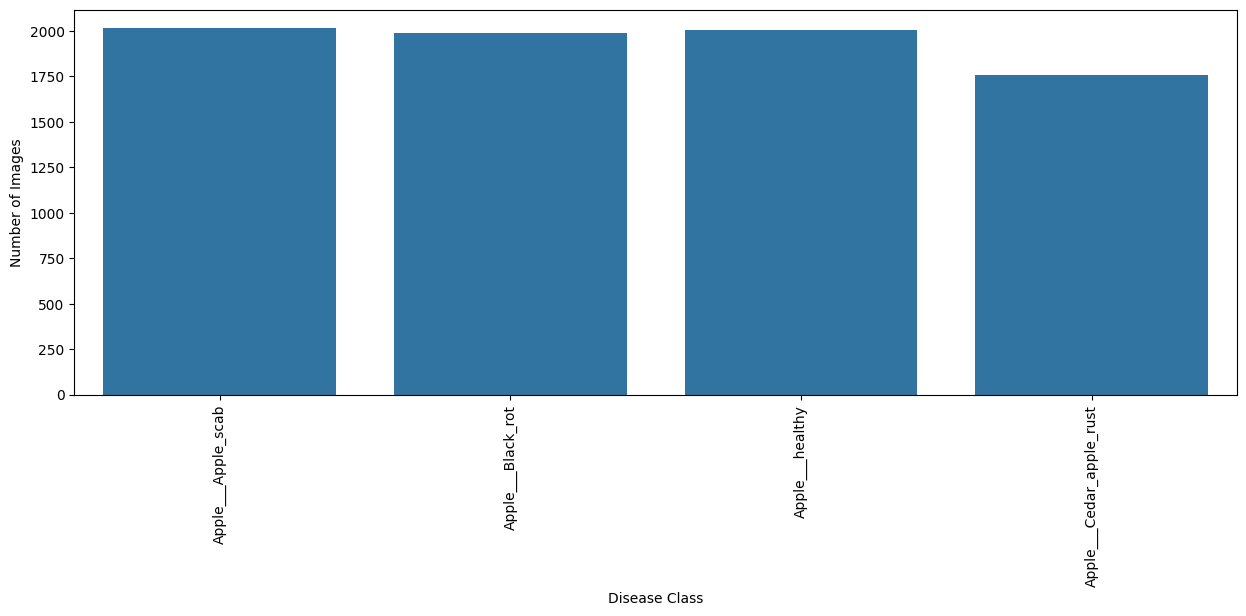

In [6]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# df = df.sort_values(by="Number of Images", ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

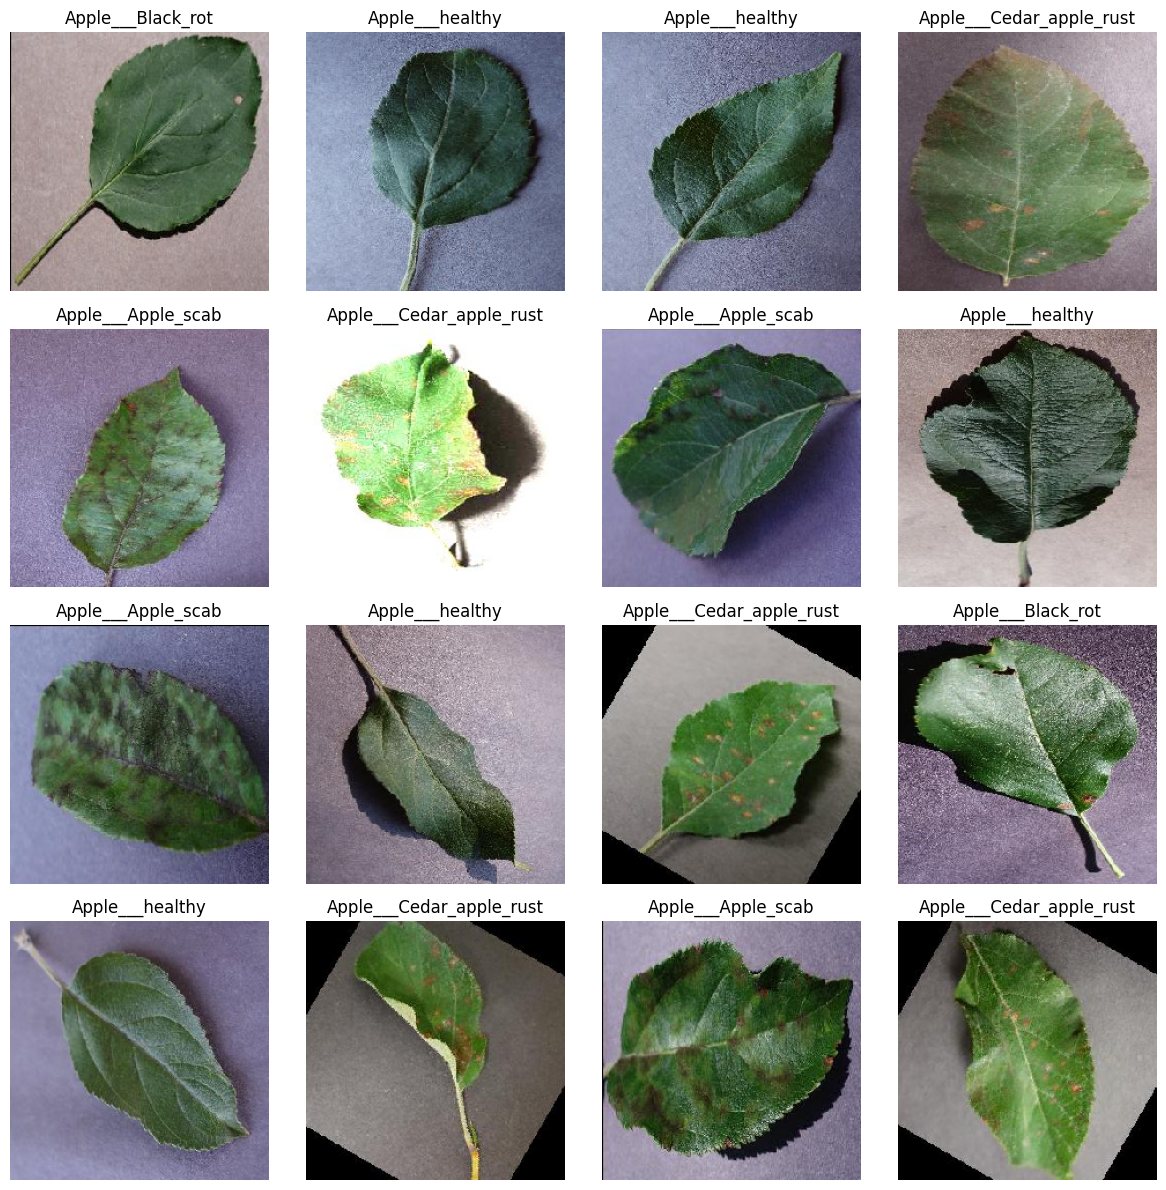

In [14]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()

In [15]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [16]:
def predict_labels_and_display(model_path, test_dir='/kaggle/input/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,236 (1.39 MB)

 Trainable params: 362,340 (1.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# train the model
model_checkpoint = ModelCheckpoint('/kaggle/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=2,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/2
14/98 ━━━━━━━━━━━━━━━━━━━━ 7:56 6s/step - accuracy: 0.5781 - loss: 1.1106

KeyboardInterrupt: 

In [ ]:
model.save('/kaggle/working/cnn_model.keras')

In [21]:
# show learning curves
plot_learning_curves(history)

NameError: name 'history' is not defined

In [20]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
